# Predict RTSI index with Random Forest models

[TOC]

## Import libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
import seaborn as sns
import numpy as np
from pprint import pprint
#plt.style.use('seaborn')


## Read data

                        open     high      low    close        vol
datetime                                                          
2018-01-03 10:00:00  1156.44  1160.61  1156.28  1160.46  9175259.0
2018-01-03 10:05:00  1160.48  1162.36  1159.97  1160.41  3997514.0
2018-01-03 10:10:00  1163.29  1164.22  1163.15  1164.22  5464189.0
2018-01-03 10:15:00  1164.51  1165.31  1164.38  1164.72  3112672.0
2018-01-03 10:20:00  1164.72  1164.76  1163.23  1163.61  3283276.0


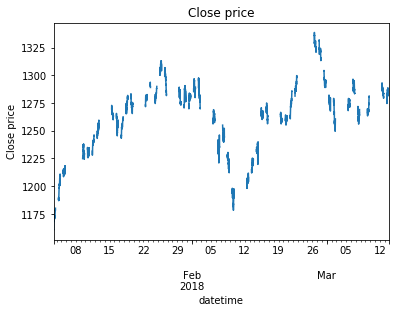

In [2]:
# Read 1M OHLCV data from file instead of pdr.DataReader('RTSI','moex',start,end) because moex network source doesn't allow often downloads
df=pd.read_csv("/home/dima/projects/stock-predictor/data/RI.RTSI_180101_180313.csv", 
               parse_dates={'datetime':[2,3]}, 
               index_col='datetime')
#df=df.loc['2018-01-09']
df=df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df.columns=['open','high','low','close','vol']
# Resample 1Min OHLC to 5Min OHLC
df=df.resample('5Min').agg({
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last',
        'vol': 'sum'})
print(df.head())
df['close'].plot(title = 'Close price')
plt.ylabel('Close price')
plt.show()

## Prepare data

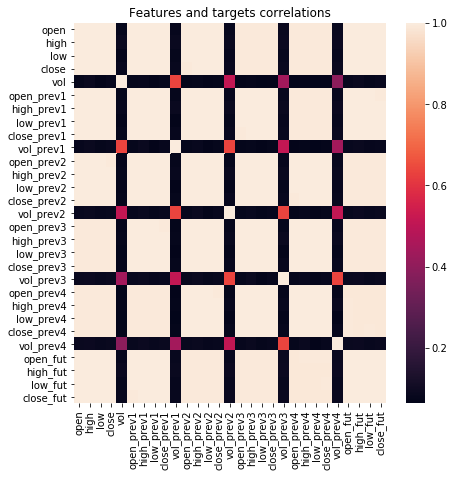

In [78]:
#lag = 5
# Fill in future values
target_names = ['open_fut', 'high_fut', 'low_fut', 'close_fut']
df['open_fut'] = df['open'].shift(-1)
df['high_fut'] = df['high'].shift(-1)
df['low_fut'] = df['low'].shift(-1)
df['close_fut'] = df['close'].shift(-1)

# Fill in prev values
prev_depth=5
feature_names=['open', 'high', 'low', 'close', 'vol']
for i in range(1,prev_depth):
    for name in ['open', 'high', 'low', 'close', 'vol']:
        prev_name = name+'_prev'+str(i)
        feature_names.append(prev_name)
        df[prev_name] = df[name].shift(i)
df = df.dropna()
features=df[feature_names]
targets = df[target_names]
sns.heatmap(df.loc[:,feature_names + target_names].corr())
plt.title('Features and targets correlations')
plt.rcParams["figure.figsize"]=[10,10]
plt.show()
train_X, test_X, train_y, test_y = train_test_split(features, targets, shuffle=False)



## Random Forest Regressor model

In [107]:
test_scores=[]
grid = ParameterGrid({'n_estimators': [200], 'max_depth':[6], 'max_features':[23,len(feature_names)]})

# Hyperparameter tuning
rfr = RandomForestRegressor()
for g in grid:
    print(g)
    rfr.set_params(**g)
    rfr.fit(train_X, train_y)
    train_score=rfr.score(train_X, train_y)
    test_score=rfr.score(test_X,test_y)
    print('Hyperparameters: %s; train score: %s; test score: %s' % (g, train_score, test_score))
    test_scores.append(test_score)

# Get the best hyperparams combination
best_idx=np.argmax(test_scores)
g=grid[best_idx]
print('Best hyperparameters: %s' % g)

rfr.set_params(**g)
rfr.fit(train_X, train_y)
y = rfr.predict(test_X)
print('Train score: %s' % rfr.score(train_X, train_y))
print('Test score: %s' % rfr.score(test_X, test_y))


{'max_depth': 6, 'max_features': 23, 'n_estimators': 200}
Hyperparameters: {'max_depth': 6, 'max_features': 23, 'n_estimators': 200}; train score: 0.998702106081; test score: 0.910029160841
{'max_depth': 6, 'max_features': 25, 'n_estimators': 200}
Hyperparameters: {'max_depth': 6, 'max_features': 25, 'n_estimators': 200}; train score: 0.99873514223; test score: 0.909791703363
Best hyperparameters: {'n_estimators': 200, 'max_features': 23, 'max_depth': 6}
Train score: 0.998702284134
Test score: 0.910010006411


### Random Forest Regressor prediction EDA

0    1289.360290
1    1289.361574
2    1289.371391
3    1289.515017
4    1289.516351
Name: close_fut, dtype: float64


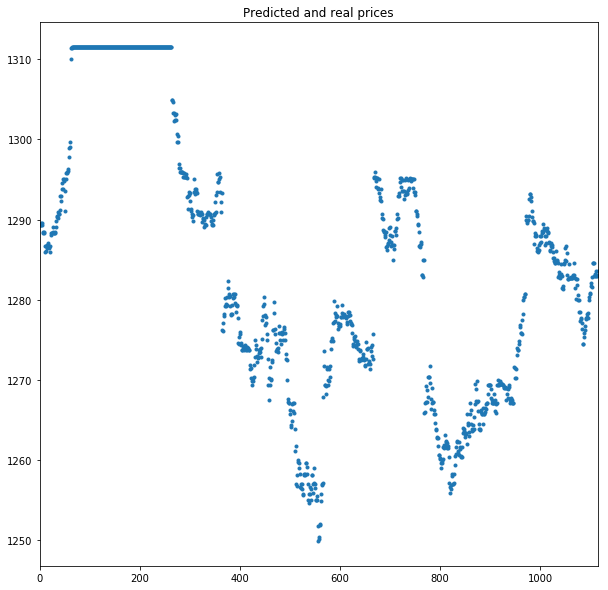

AttributeError: module 'seaborn' has no attribute 'scatterplot'

In [132]:
data = pd.DataFrame(y.reshape(test_y.shape), columns=target_names)['close_fut']
#data.rename({'close_fut': 'predicted'})
#data['real']=test_y['close_fut']
print(data.head())

data.plot(linestyle='none', marker='.', title = 'Predicted and real prices')
#data.plot(title = 'Predicted and real prices')
plt.show()

sns.scatterplot(x = test_y, y = y)
plt.title('Predicted and real prices scatterplot')
plt.xlabel('real price')
plt.ylabel('predicted price')
plt.show()

(data['predicted'] - data['price']).plot(title = 'Predicted diff', linestyle='none', marker='.',)
plt.ylabel('predicted price - real price')
plt.show()


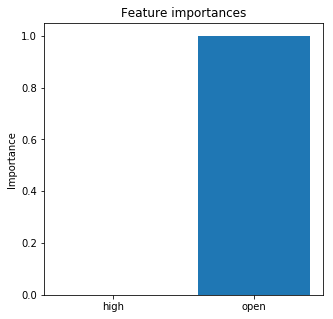

In [60]:

# Analyze feature importances
imp = rfr.feature_importances_
sorted_idx=np.argsort(imp)[::-1]
sorted_labels = np.array(train_X.columns[sorted_idx])

plt.bar(sorted_labels, imp[sorted_idx])
plt.title('Feature importances')
plt.ylabel('Importance')

plt.show()

In [ ]:
ToDo: Add indicators, past bars to input...